# 7.프로젝트 : 주식 예측에 도전해 보자

-------------------

## 1.시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [2]:
ts = df['Close']
print(type(ts))

ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

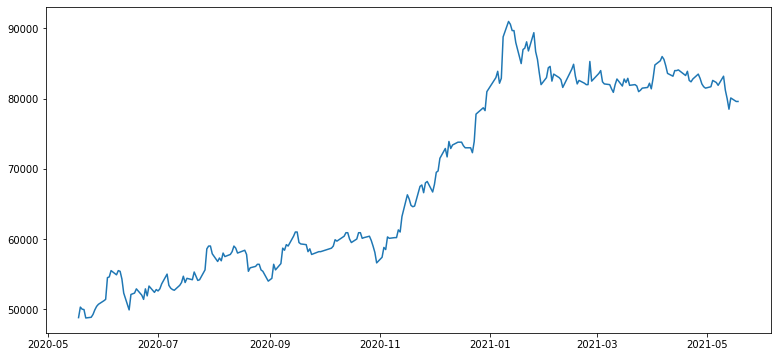

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

--------------------

## 2.각종 전처리 수행

### -결측치 처리

In [4]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


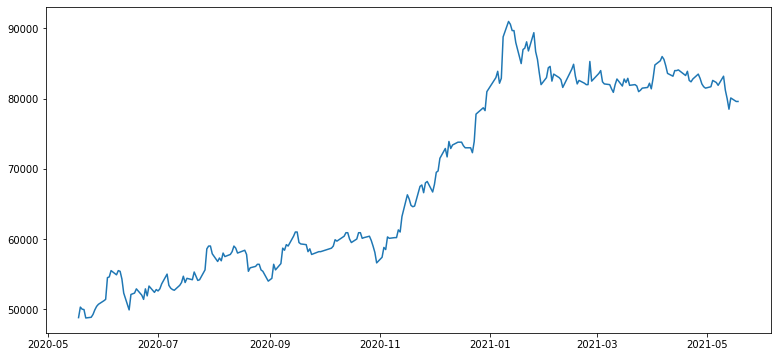

In [5]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()    


    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

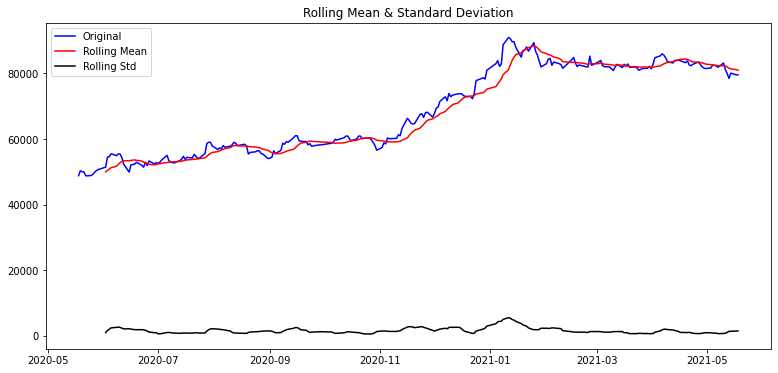

In [7]:
plot_rolling_statistics(ts, window=12)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### - 로그변환

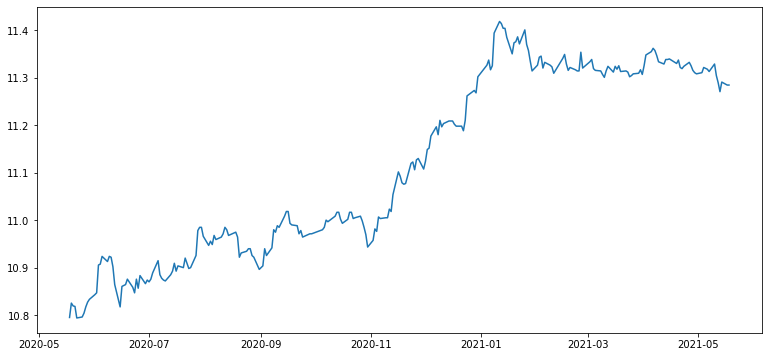

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

----------------

## 3.시계열 안정성 분석

### - 정성적 그래프 분석

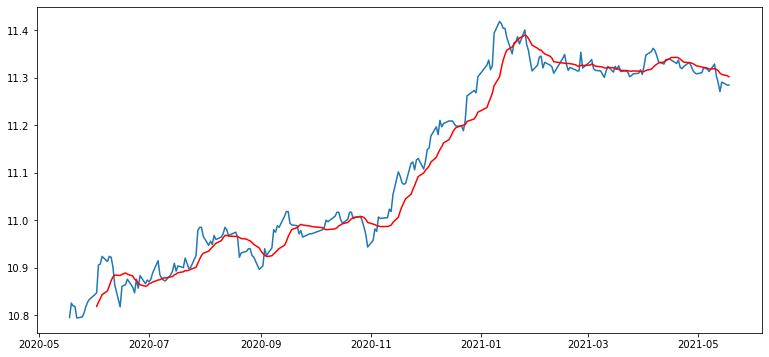

In [11]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [13]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

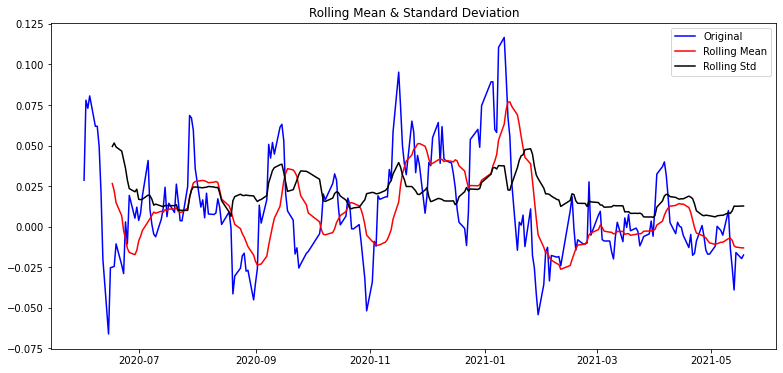

In [14]:
plot_rolling_statistics(ts_log_moving_avg)

In [15]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [16]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

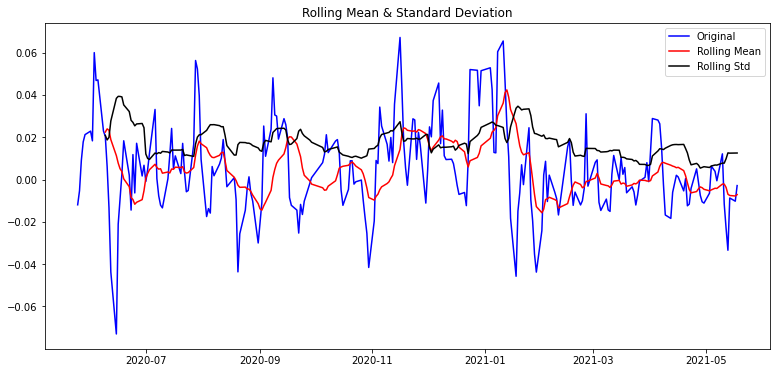

In [17]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [18]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


### - 정량적 Augmented Dicky-Fuller Test

In [19]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


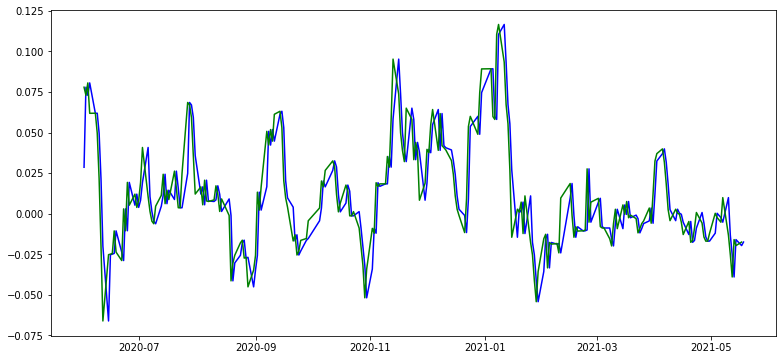

In [20]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

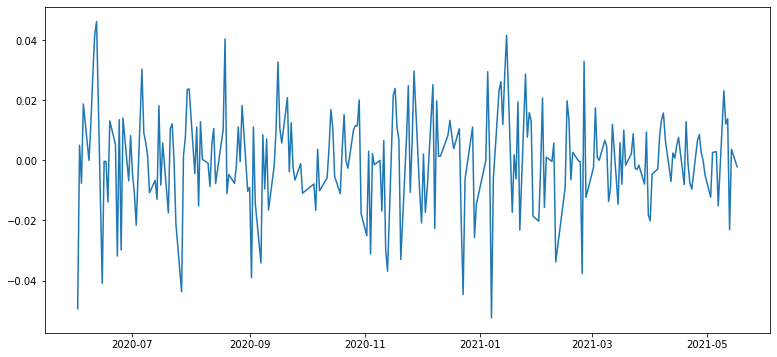

In [21]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

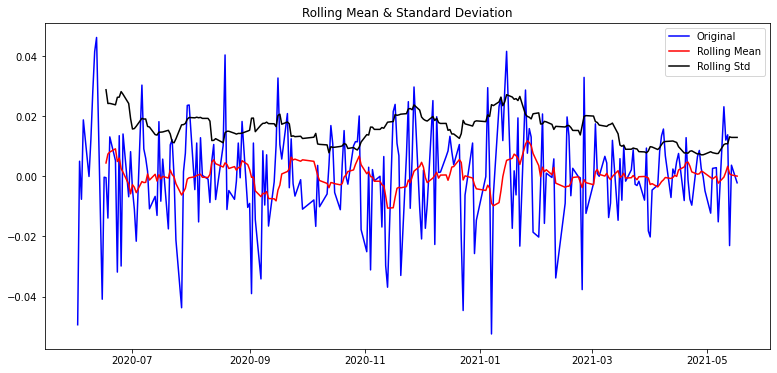

In [22]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


### - 시계열 분해(Time Series Decomposition)

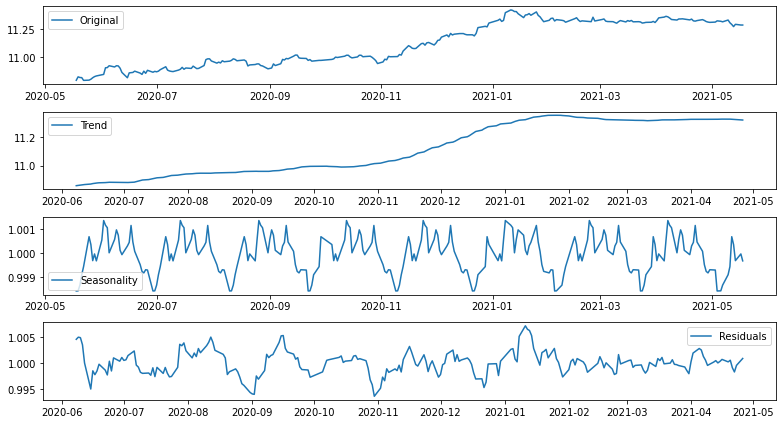

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### - Residual 안정성 확인

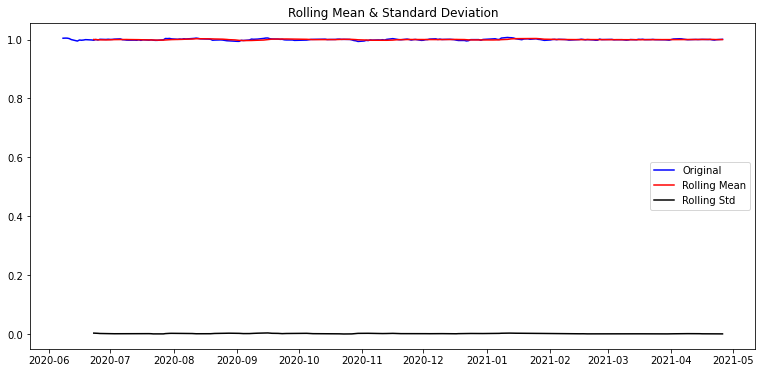

In [25]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [26]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


--------------------

## 4.학습, 테스트 데이터셋 생성

### - 학습,테스트 데이터셋 분리

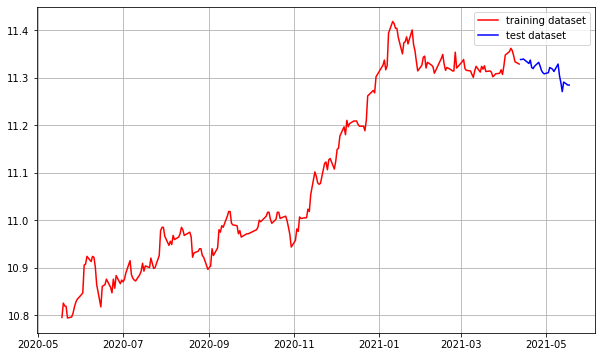

In [27]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [28]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


----------------------

## 5.적정 ARIMA 모수 찾기 

### - ACF, PACF 그려보기 -> p,q 구하기

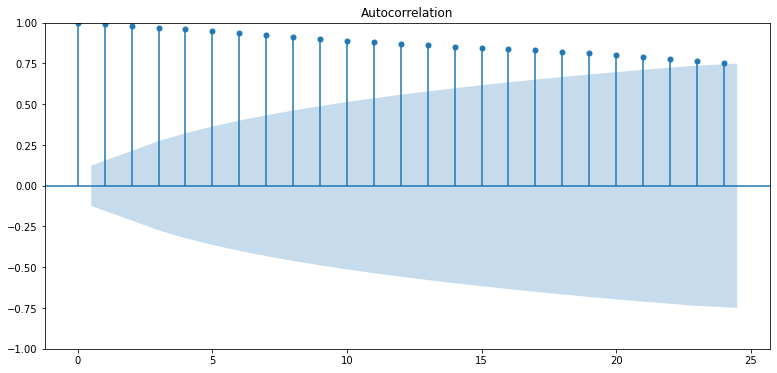

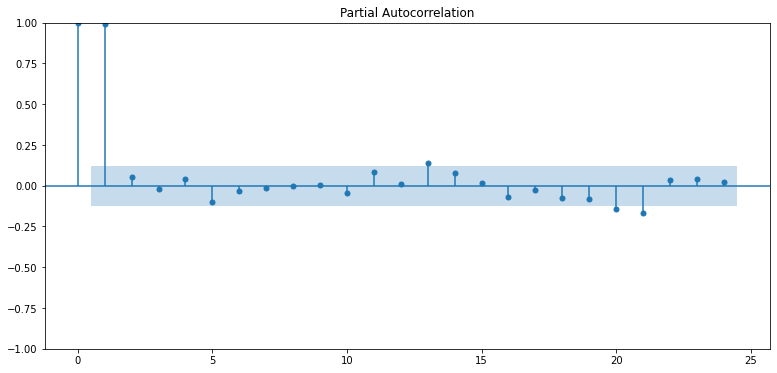

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### - 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


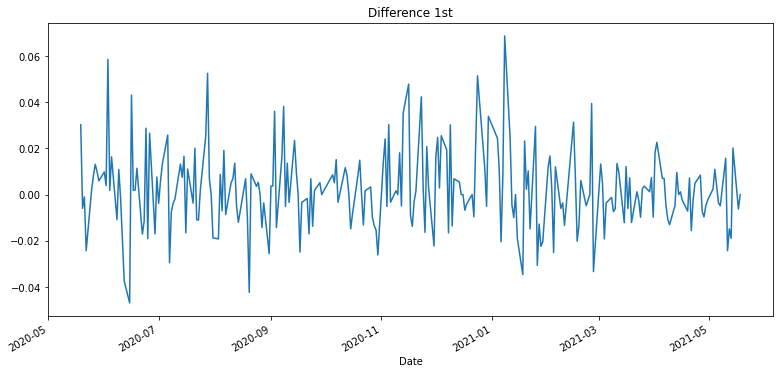

In [30]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

-----------------------

## 6.ARIMA 모델 훈련과 테스트

### - ARIMA 모델 빌드와 훈련

In [31]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(13, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(13, 1, 0)   Log Likelihood                 587.273
Date:                Fri, 06 Jan 2023   AIC                          -1146.546
Time:                        02:37:07   BIC                          -1098.783
Sample:                             0   HQIC                         -1127.267
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0431      0.066      0.649      0.516      -0.087       0.173
ar.L2         -0.0162      0.080     -0.204      0.839      -0.172       0.140
ar.L3         -0.0405      0.075     -0.541      0.5

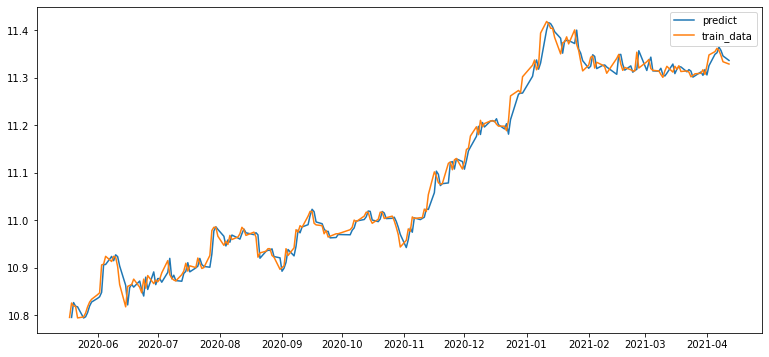

In [32]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

### - 모델 테스트 및 플로팅

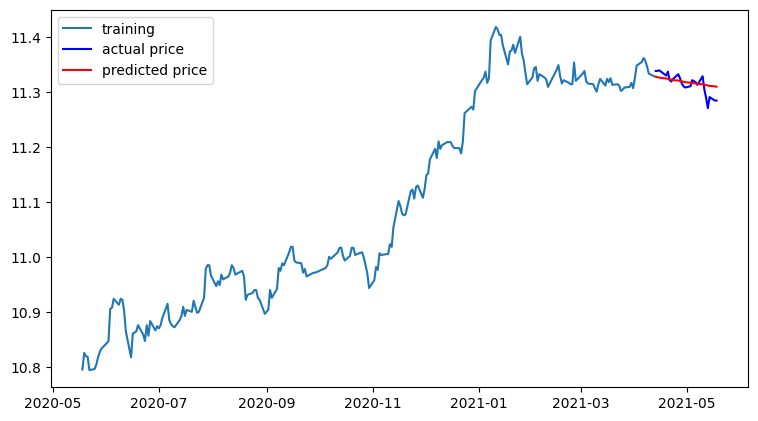

In [33]:
model = ARIMA(train_data, order=(2, 0, 2)) 
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc.index = test_data.index
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 


# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### - 최종 예측 모델 정확도 측정(MAPE)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1427822.3540262028
MAE:  933.7248352184944
RMSE:  1194.9152078813804
MAPE: 1.15%


-------------------------

## 7.다른 주식 종목 예측해 보기

# 다른 종목인 현대자동차에 대해 알아보자!!

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005380.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-05,214000.0,217500.0,212000.0,213500.0,212352.15625,1175411
2022-01-06,210000.0,216500.0,210000.0,214000.0,212849.46875,866582
2022-01-07,214500.0,216500.0,213500.0,215000.0,213844.09375,577852
2022-01-10,214000.0,215000.0,209000.0,209500.0,208373.65625,744261
2022-01-11,209500.0,211500.0,209000.0,210500.0,209368.28125,482235


In [36]:
hd = df['Close']
print(type(ts))

hd.head()

<class 'pandas.core.series.Series'>


Date
2022-01-05    213500.0
2022-01-06    214000.0
2022-01-07    215000.0
2022-01-10    209500.0
2022-01-11    210500.0
Name: Close, dtype: float64

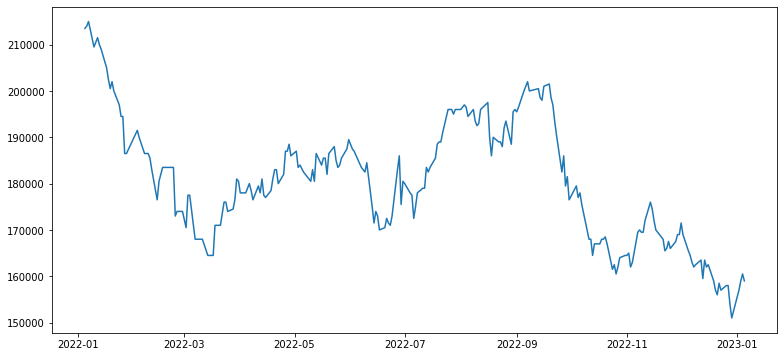

In [37]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(hd)

In [38]:
hd[hd.isna()]

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


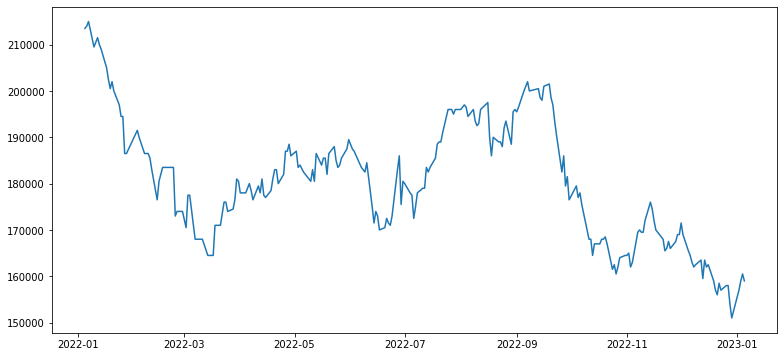

In [39]:
hd=hd.interpolate(method='time')

print(hd[hd.isna()])

plt.plot(hd)

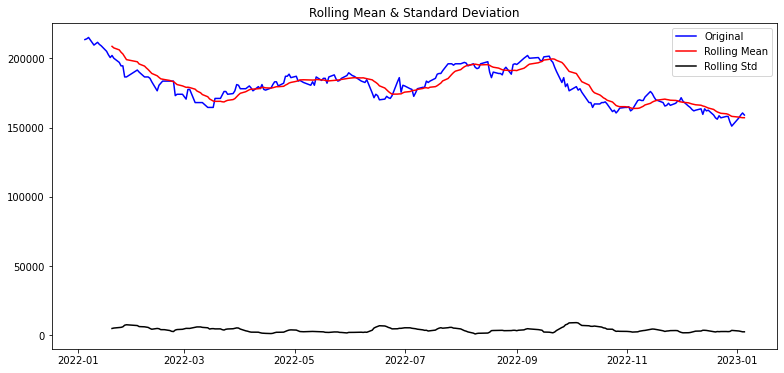

In [40]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()    


    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(hd, window=12)

In [41]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(hd)

Results of Dickey-Fuller Test:
Test Statistic                  -2.323792
p-value                          0.164409
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


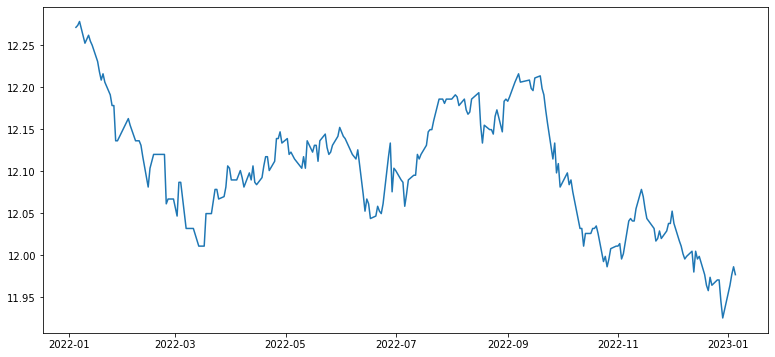

In [42]:
hd_log = np.log(hd)
plt.plot(hd_log)

In [43]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


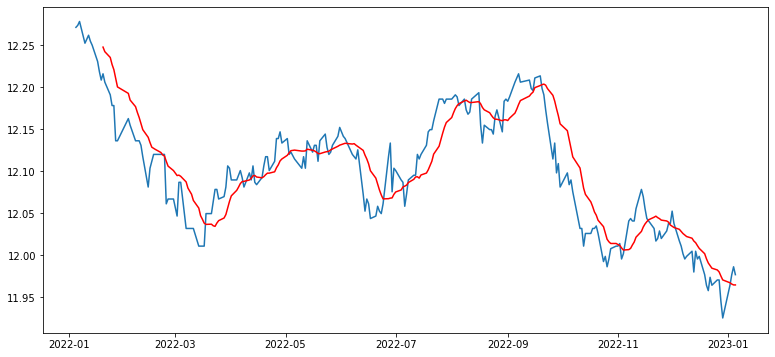

In [44]:
moving_avg = hd_log.rolling(window=12).mean()
plt.plot(hd_log)
plt.plot(moving_avg, color='red')

In [45]:
hd_log_moving_avg = hd_log - moving_avg
hd_log_moving_avg.head(15)

Date
2022-01-05         NaN
2022-01-06         NaN
2022-01-07         NaN
2022-01-10         NaN
2022-01-11         NaN
2022-01-12         NaN
2022-01-13         NaN
2022-01-14         NaN
2022-01-17         NaN
2022-01-18         NaN
2022-01-19         NaN
2022-01-20   -0.031812
2022-01-21   -0.036319
2022-01-24   -0.044535
2022-01-25   -0.048956
Name: Close, dtype: float64

In [46]:
hd_log_moving_avg.dropna(inplace=True)
hd_log_moving_avg.head(15)

Date
2022-01-20   -0.031812
2022-01-21   -0.036319
2022-01-24   -0.044535
2022-01-25   -0.048956
2022-01-26   -0.042765
2022-01-27   -0.074678
2022-01-28   -0.064196
2022-02-03   -0.030054
2022-02-04   -0.029975
2022-02-07   -0.040686
2022-02-08   -0.033827
2022-02-09   -0.027796
2022-02-10   -0.026071
2022-02-11   -0.032237
2022-02-14   -0.059245
Name: Close, dtype: float64

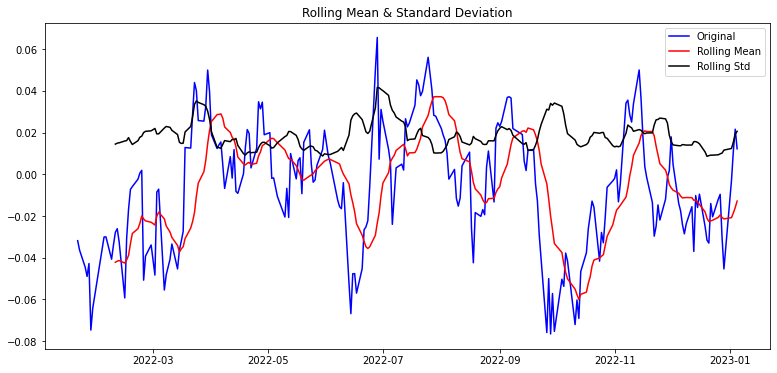

In [47]:
plot_rolling_statistics(hd_log_moving_avg)

In [48]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [49]:
moving_avg_6 = hd_log.rolling(window=6).mean()
hd_log_moving_avg_6 = hd_log - moving_avg_6
hd_log_moving_avg_6.dropna(inplace=True)

augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


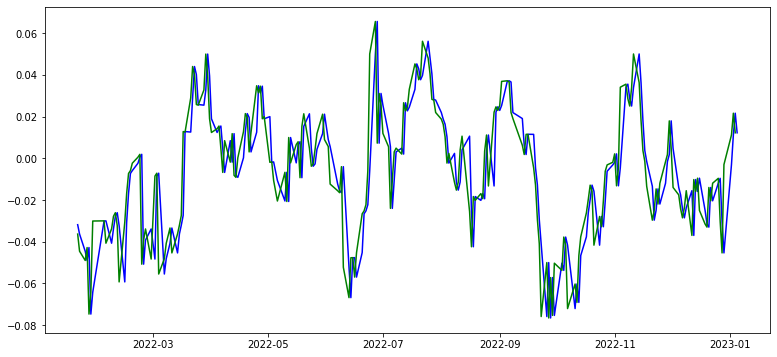

In [50]:
hd_log_moving_avg_shift = hd_log_moving_avg.shift(-1)

plt.plot(hd_log_moving_avg, color='blue')
plt.plot(hd_log_moving_avg_shift, color='green')

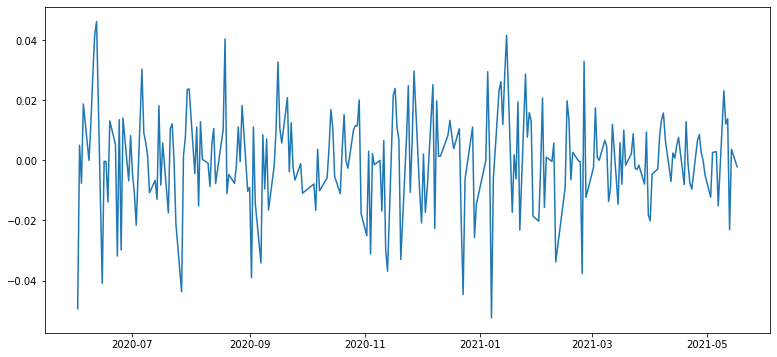

In [51]:
hd_log_moving_avg_diff = hd_log_moving_avg - hd_log_moving_avg_shift
hd_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

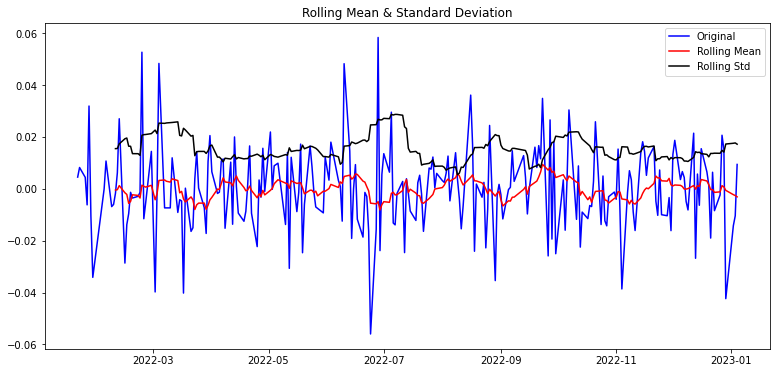

In [52]:
plot_rolling_statistics(hd_log_moving_avg_diff)

In [53]:
augmented_dickey_fuller_test(hd_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.286255e+01
p-value                        5.074297e-24
#Lags Used                     1.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


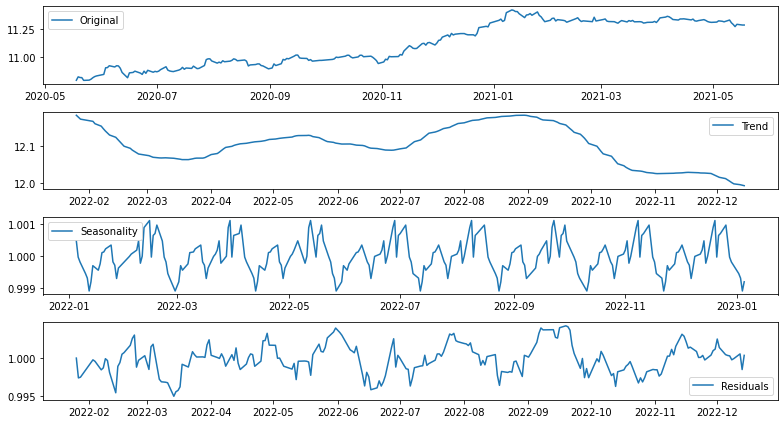

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(hd_log, model='multiplicative', period = 30) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

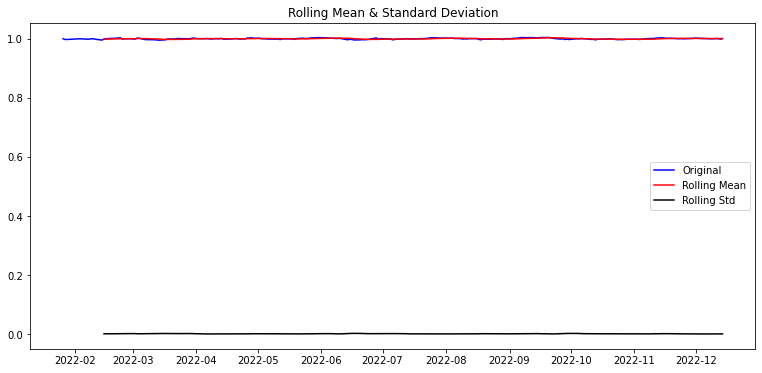

In [55]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [56]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.160626
p-value                          0.000011
#Lags Used                       0.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


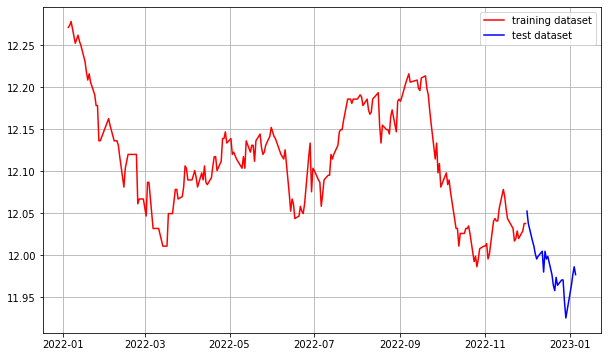

In [57]:
train_data, test_data = hd_log[:int(len(hd_log)*0.9)], hd_log[int(len(hd_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [58]:
print(hd_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2022-01-05    12.271392
2022-01-06    12.273731
Name: Close, dtype: float64
(222,)
(25,)


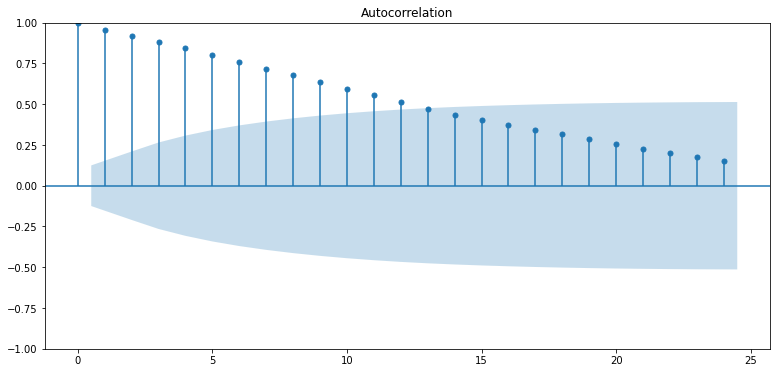

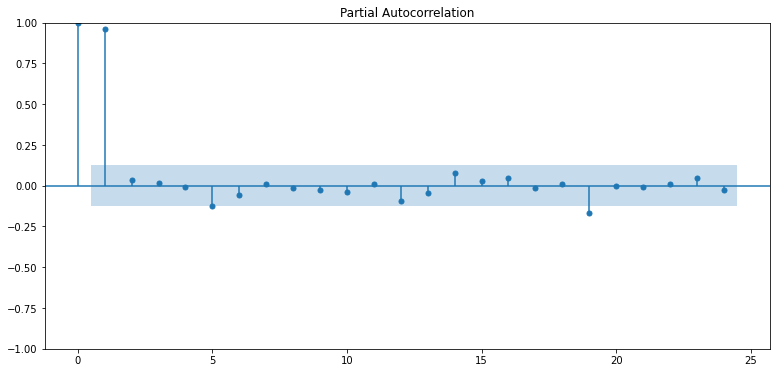

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(hd_log)  
plot_pacf(hd_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.253242e+01
p-value                        2.412247e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


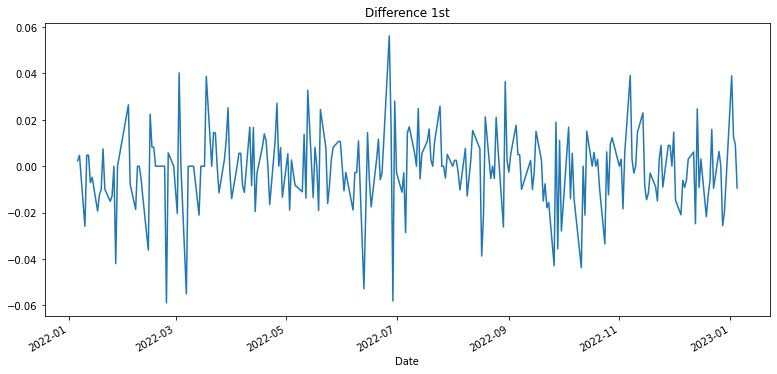

In [60]:
diff_1 = hd_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [61]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(13, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                ARIMA(13, 1, 0)   Log Likelihood                 595.693
Date:                Fri, 06 Jan 2023   AIC                          -1163.386
Time:                        02:37:15   BIC                          -1115.812
Sample:                             0   HQIC                         -1144.176
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0808      0.079     -1.026      0.305      -0.235       0.073
ar.L2         -0.0787      0.063     -1.258      0.208      -0.201       0.044
ar.L3          0.0446      0.085      0.524      0.6

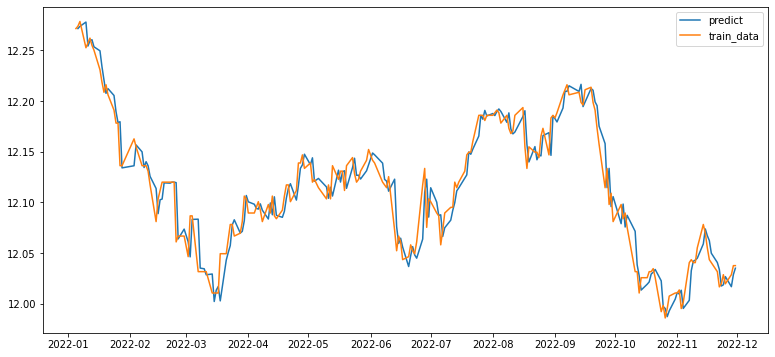

In [62]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

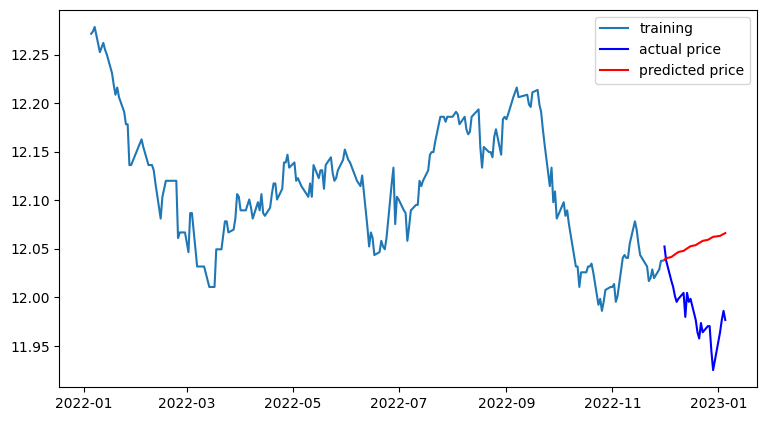

In [63]:
model = ARIMA(train_data, order=(2, 0, 2))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc.index = test_data.index

fc_series = pd.Series(fc, index=test_data.index) 



plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  155629051.86951765
MAE:  11333.551299541667
RMSE:  12475.137348723567
MAPE: 7.15%


# 회고

### 수업 내용을 초반 내용만 보고 난 이후에 프로젝트를 하다 보니 이해가 되지 않는 부분들이 많았다.

### 수업 내용의 어느정도는 머리로 이해가 되나 역시나 표현하기까지는 많은 시간이 걸릴것으로 예상된다.

### 주식 종목을 통해 데이터를 정밀하게 분석 해볼수 있는 시간이어서 좋았다.

### 삼성전자 종목은 MAPE값이 1.15%로 굉장히 좋은 결과를 낸 반면, 추가로 진행했던 현대자동차 종목은 7.15%로 애매한 수치를 기록하였다. 향후 종목의 변동성이 크게 작용될것으로 예측 및 예상된다.

### 실제 데이터와 훈련데이터를 분리하여 보다 좋은 결과값을 얻어 낼수 있는 훈련을 통하여 예측을 할수 있다는 점에서 보다 더 정밀하게 분석하여 예측을 할수 있다면 실투자에서도 반영해볼만 할것 같다.